# Supervised Machine Learning on Secondary School Performance

### STAT 527 - Jingbo Liu - Fall 2021

### Author: Gabe Taylor

# Agenda

### Data Overview ~ 6 mins
- Problem presentation/data description ~ 3 mins
- Exploratory Data Analysis (EDA) ~ 2 mins
- Data Preprocessing ~ 1 min

### Modeling ~ 20 mins
- **Lasso** tuning and modeling ~ 3 mins
- **Decision Tree** introduction ~ 5 mins
- **Decision Tree** tuning and modeling ~ 3 mins
- **Gradient boosting** introduction ~ 5 mins
- **Gradient boosting** tuning and modeling ~ 3 mins
- Variable Importances ~ 1 mins

### Conclusion ~ 2 mins
- Performance comparison ~ 1 min
- Conclusion ~ 1 min

# Data Description

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("fivethirtyeight")

In [104]:
df = pd.read_csv("/Users/gabrieltaylor/Downloads/crimedata.csv",sep='\s*,\s*',encoding='latin-1',engine='python',na_values=["?"]) # Read the csv file into dataframe
df = df.rename(columns={'Êcommunityname':'communityName'})

In [105]:
df

,communityName,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,1,16656,2.40,1.70,97.35,0.50,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,1,11245,2.76,0.53,89.16,1.17,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,Mercedcity,CA,NaN,NaN,10,56216,3.07,6.87,61.68,15.23,...,1376.0,2268.72,2563.0,4225.82,489.0,806.25,34.0,56.06,545.75,7356.84
2211,Pinevillecity,LA,NaN,NaN,10,12251,2.68,21.18,76.65,1.52,...,104.0,860.43,574.0,4748.90,24.0,198.56,2.0,16.55,124.10,5824.44
2212,Yucaipacity,CA,NaN,NaN,10,32824,2.46,0.52,92.62,0.98,...,628.0,1709.26,895.0,2435.97,179.0,487.19,8.0,21.77,353.83,4654.20
2213,Beevillecity,TX,NaN,NaN,10,13547,2.89,3.37,69.91,0.90,...,192.0,1508.01,474.0,3722.90,13.0,102.10,1.0,7.85,691.17,5340.87


In [113]:
drop_cols = df.iloc[:, -18:-2].columns.to_list()
df = df.drop(drop_cols, axis = 1)

In [114]:
df = df.iloc[df['ViolentCrimesPerPop'].dropna().index.to_list(), : ]

In [115]:
miss_rate = df.isna().mean().sort_values()
keep_cols = miss_rate[miss_rate == 0]
df = df[keep_cols.index.to_list()]

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2214
Columns: 105 entries, communityName to blackPerCap
dtypes: float64(75), int64(28), object(2)
memory usage: 1.6+ MB


In [117]:
df = df.drop(['communityName', 'fold'], axis = 1)

# EDA

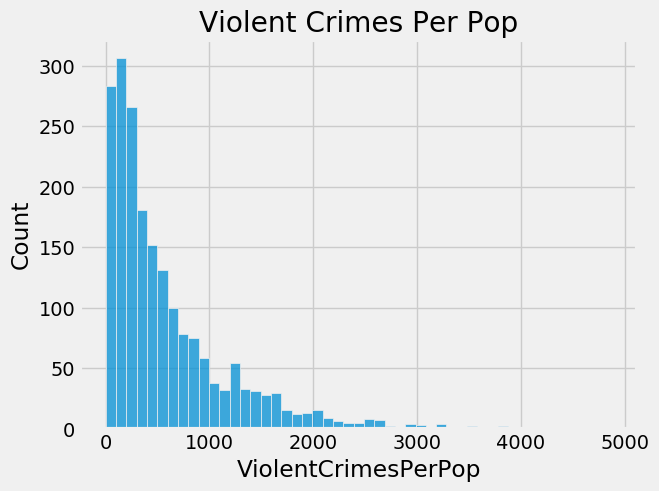

In [118]:
sns.histplot(data = df, x = 'ViolentCrimesPerPop')
plt.title('Violent Crimes Per Pop')
plt.show()

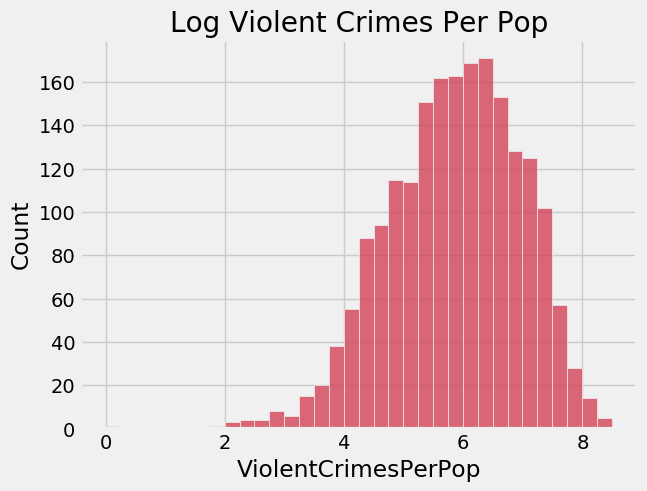

In [227]:
sns.histplot(x = df['ViolentCrimesPerPop'].apply(lambda x: x + 1).apply(np.log))
plt.title('Log Violent Crimes Per Pop')
plt.show()

# Data Pre-processing

In [228]:
df['LogViolentCrimesPerPop'] = df['ViolentCrimesPerPop'].apply(lambda x: x + 1).apply(np.log)

In [175]:
corr_mat = df.corr()
high_corr = {}

for col in corr_mat:
    high_cor_vars = corr_mat[col].where(abs(corr_mat[col]) > 0.9).dropna().index[1:].to_list()
    
    if len(high_cor_vars) > 0:
        high_corr[col] = high_cor_vars

In [176]:
high_corr

{'PctHousOwnOcc': ['PctPersOwnOccup'],
 'HousVacant': ['population', 'numbUrban', 'NumUnderPov'],
 'PctPersOwnOccup': ['PctPersOwnOccup'],
 'PersPerOwnOccHous': ['PersPerOccupHous'],
 'PersPerOccupHous': ['PersPerOccupHous', 'PersPerFam'],
 'PctLargHouseOccup': ['PctLargHouseFam', 'PersPerFam'],
 'PctLargHouseFam': ['PctLargHouseFam'],
 'PctNotSpeakEnglWell': ['PctSpeakEnglOnly'],
 'PctRecImmig10': ['PctRecImmig8',
  'PctRecImmig5',
  'PctRecentImmig',
  'PctForeignBorn'],
 'PctRecImmig8': ['PctRecImmig8',
  'PctRecImmig5',
  'PctRecentImmig',
  'PctForeignBorn'],
 'PctRecImmig5': ['PctRecImmig8',
  'PctRecImmig5',
  'PctRecentImmig',
  'PctForeignBorn'],
 'PctRecentImmig': ['PctRecImmig8',
  'PctRecImmig5',
  'PctRecentImmig',
  'PctForeignBorn'],
 'PctImmigRec10': ['PctImmigRec8'],
 'PctImmigRec8': ['PctImmigRec8', 'PctImmigRec5'],
 'PctImmigRec5': ['PctImmigRec5', 'PctImmigRecent'],
 'PctImmigRecent': ['PctImmigRecent'],
 'NumImmig': ['NumStreet',
  'NumKidsBornNeverMar',
  'populat

# Mean Model

In [119]:
def rmse(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

$$RMSE = \sqrt{\frac{1}{n} \sum_{i = 1}^n (y_i - \hat y_i)^2}$$

$$RMSE = \sqrt{\frac{1}{n} \sum_{i = 1}^n (\ln(y_i) - \ln (\hat y_i))^2} = \sqrt{\frac{1}{n} \sum_{i = 1}^n \ln \left(\frac{y_i}{\hat y_i} \right)^2}$$

In [120]:
print("Mean Model RMSE: " + str(round(rmse(df['ViolentCrimesPerPop'], np.mean(df['ViolentCrimesPerPop'])), 3)))

Mean Model RMSE: 614.63


# Cross-Validation

### 10 Fold Cross Validation

1. Split data into 10 folds
2. Reserve 1 fold for validation (scoring)
3. Train model on remaining 9 folds

![](imgs/CV1.png)

### How to evaluate performance

One could take the average error over all of the folds:

![](imgs/CV2.png)


Alternatively, one could append the cross-validation predictions to the original training data, and score the predictions using the the full training observations

![](imgs/CV3.png)

### What about the Test Data?

- In practice, it is useful to score the final model on a holdout set in order to evaluate how well the the model will generalize to unseen data. 

- In the project, due to the small training size, we will not reserve a portion of the data for a hold out, but instead, we will construct a 'test set' using the 10 folds as illustrated in the second method in previous slide.

- For consistency, this is default cross-validation scoring in H2o

# OLS Model

In [77]:
import h2o
h2o.init()
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 days 0 hours 7 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 21 days
H2O_cluster_name:,H2O_from_python_gabrieltaylor_5j5pbt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,959 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [229]:
full = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [231]:
predictors = full.columns
target = 'ViolentCrimesPerPop'
logtarget = 'LogViolentCrimesPerPop'
predictors.remove(target)
predictors.remove(logtarget)
predictors.remove('state')

In [253]:
ols_model = H2OGeneralizedLinearEstimator(family= "gaussian",
                                          fold_column = 'state',
#                                           nfolds = 10,
                                          lambda_ = 0,
                                          seed = 69)
ols_model.train(predictors, target, training_frame= full)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1637777366396_2876


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,None,101,101,1,Key_Frame__upload_9f505679e14311cd84f3ec8d3b3b434f.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 122683.51200169133
RMSE: 350.2620618932221
MAE: 237.4745192449375
RMSLE: NaN
R^2: 0.6752432327362854
Mean Residual Deviance: 122683.51200169133
Null degrees of freedom: 1993
Residual degrees of freedom: 1892
Null deviance: 753274288.9164218
Residual deviance: 244630922.9313725
AIC: 29229.149181259978

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 174279.4876134656
RMSE: 417.46794800734773
MAE: 273.5841494715036
RMSLE: NaN
R^2: 0.5386630030859724
Mean Residual Deviance: 174279.4876134656
Null degrees of freedom: 1993
Residual degrees of freedom: 1892
Null deviance: 767373860.2665361
Residual deviance: 347513298.3012504
AIC: 29929.147457594834

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,...,cv_37_valid,cv_38_valid,cv_39_valid,cv_40_valid,cv_41_valid,cv_42_valid,cv_43_valid,cv_44_valid,cv_45_valid,cv_46_valid
0,mae,2.678022e+02,1.360516e+02,110.064064,5.200982e+02,3.513364e+02,2.410049e+02,3.044658e+02,2.357584e+02,1.755851e+02,...,1.108344e+02,2.350479e+02,2.926846e+02,1.632861e+02,3.499545e+02,312.554000,2.451911e+02,1.393275e+02,2.883279e+02,148.908460
1,mean_residual_deviance,1.629483e+05,1.847033e+05,35591.484000,5.376665e+05,3.077104e+05,9.780756e+04,2.101545e+05,1.316865e+05,4.832964e+04,...,1.433173e+04,8.670911e+04,1.644806e+05,4.404004e+04,1.685532e+05,114977.984000,9.514523e+04,3.556532e+04,1.067676e+05,30887.846000
2,mse,1.629483e+05,1.847033e+05,35591.484000,5.376665e+05,3.077104e+05,9.780756e+04,2.101545e+05,1.316865e+05,4.832964e+04,...,1.433173e+04,8.670911e+04,1.644806e+05,4.404004e+04,1.685532e+05,114977.984000,9.514523e+04,3.556532e+04,1.067676e+05,30887.846000
3,null_deviance,1.668204e+07,2.488989e+07,329652.000000,4.699161e+07,1.395440e+07,2.496186e+06,1.116470e+08,5.490992e+06,2.058842e+07,...,1.349154e+06,9.789623e+06,3.141980e+07,4.027139e+06,5.280208e+06,911005.700000,7.215642e+06,1.238242e+07,2.434912e+06,793580.000000
4,r2,-inf,NaN,0.675637,3.952744e-01,4.312030e-01,2.069898e-01,3.734717e-01,3.894068e-01,7.353404e-01,...,1.676889e-01,6.676633e-01,1.790606e-01,-1.981796e-01,-9.320035e-02,-35.509666,4.672298e-01,-2.263536e-01,2.857992e-01,-0.153058
5,residual_deviance,7.554637e+06,1.129529e+07,106774.450000,2.311966e+07,7.692761e+06,1.956151e+06,5.842294e+07,3.292162e+06,3.334745e+06,...,1.289856e+05,3.034819e+06,2.565897e+07,1.056961e+06,5.562256e+06,459911.940000,3.805810e+06,2.133920e+06,1.494747e+06,216214.920000
6,rmse,3.579312e+02,1.886998e+02,188.657060,7.332574e+02,5.547165e+02,3.127420e+02,4.584261e+02,3.628863e+02,2.198400e+02,...,1.197152e+02,2.944641e+02,4.055620e+02,2.098572e+02,4.105523e+02,339.084050,3.084562e+02,1.885877e+02,3.267531e+02,175.749390
7,rmsle,7.601988e-01,3.746055e-01,0.776234,9.192275e-01,8.397064e-01,7.071791e-01,NaN,6.461895e-01,NaN,...,NaN,6.731133e-01,NaN,NaN,8.231529e-01,1.492286,NaN,NaN,1.297646e+00,0.621523



Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2
0,,2021-11-28 14:11:25,0.000 sec,0,7.53274e+08,377770,,,,
1,,2021-11-28 14:11:25,0.019 sec,1,,,350.262,122684,237.475,0.675243



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TotalPctDiv,699.578918,1.000000,0.091594
1,PctPersOwnOccup,655.952393,0.937639,0.085882
2,PctHousOwnOcc,581.597595,0.831354,0.076147
3,MalePctDivorce,427.238007,0.610707,0.055937
4,FemalePctDiv,315.331604,0.450745,0.041285
5,PersPerOccupHous,202.714096,0.289766,0.026541
6,numbUrban,198.843582,0.284233,0.026034
7,PctKids2Par,179.256744,0.256235,0.023469
8,MedRent,164.500015,0.235141,0.021537
9,agePct12t29,161.765961,0.231233,0.021179



See the whole table with table.as_data_frame()


### Summary

In [254]:
print("Training RMSE: " + str(round(ols_model.rmse(train = True), 3)))
print("Cross Validation RMSE: " + str(round(ols_model.rmse(xval = True), 3)))

Training RMSE: 350.262
Cross Validation RMSE: 417.468


In [234]:
ols_model._model_json['output']['coefficients_table'].as_data_frame()[['names', 'standardized_coefficients']].sort_values('standardized_coefficients', ascending = False)

,names,standardized_coefficients
0,Intercept,5.856205
74,population,2.910576
55,medFamInc,0.739995
10,PersPerOccupHous,0.558509
15,PctRecImmig8,0.401582
...,...,...
82,PersPerFam,-0.487508
80,PctKids2Par,-0.543090
62,medIncome,-0.608161
14,PctRecImmig10,-0.612318


# LASSO Model

In [255]:
glm_model = H2OGeneralizedLinearEstimator(family= "gaussian",
                                          lambda_search = True,
                                          alpha = 1,
#                                           nfolds = 10,
                                          fold_column = 'state',
                                          seed = 69,
                                          standardize = True)
glm_model.train(predictors, target, training_frame= full)

print("Training RMSE: " + str(round(glm_model.rmse(train = True), 3)))
print("Cross Validation RMSE: " + str(round(glm_model.rmse(xval = True), 3)))

KeyboardInterrupt: 

### Summary

### Coefficients

In [237]:
glm_model._model_json['output']['coefficients_table'].as_data_frame()[['names', 'standardized_coefficients']]

,names,standardized_coefficients
0,Intercept,5.856205
1,PctHousOwnOcc,0.000000
2,PctHousOccup,-0.041701
3,HousVacant,0.048224
4,MedNumBR,0.000000
...,...,...
97,NumUnderPov,0.000000
98,HispPerCap,-0.002005
99,AsianPerCap,0.007484
100,PctEmplManu,-0.029107


In [238]:
l1_coef  =  glm_model._model_json['output']['coefficients_table']\
                     .as_data_frame()\
                     .query("standardized_coefficients != 0")\
                     .sort_values('standardized_coefficients', ascending = False)\
                     .reset_index(drop = True)
l1_coef[['names', 'standardized_coefficients']]

,names,standardized_coefficients
0,Intercept,5.856205
1,MalePctDivorce,0.134540
2,pctUrban,0.114913
3,RentQrange,0.075929
4,racePctHisp,0.057422
5,PersPerRentOccHous,0.053452
6,HousVacant,0.048224
7,LemasPctOfficDrugUn,0.045728
8,PctSameState85,0.028382
9,PctTeen2Par,0.027900


In [239]:
sign = lambda x: 'Positive' if x > 0 else 'Negative'
l1_coef['sign'] = l1_coef['coefficients'].apply(sign)
l1_coef['abs'] = l1_coef['standardized_coefficients'].apply(abs)
l1_coef = l1_coef.sort_values('standardized_coefficients').iloc[ :-1, :].reset_index(drop = True)

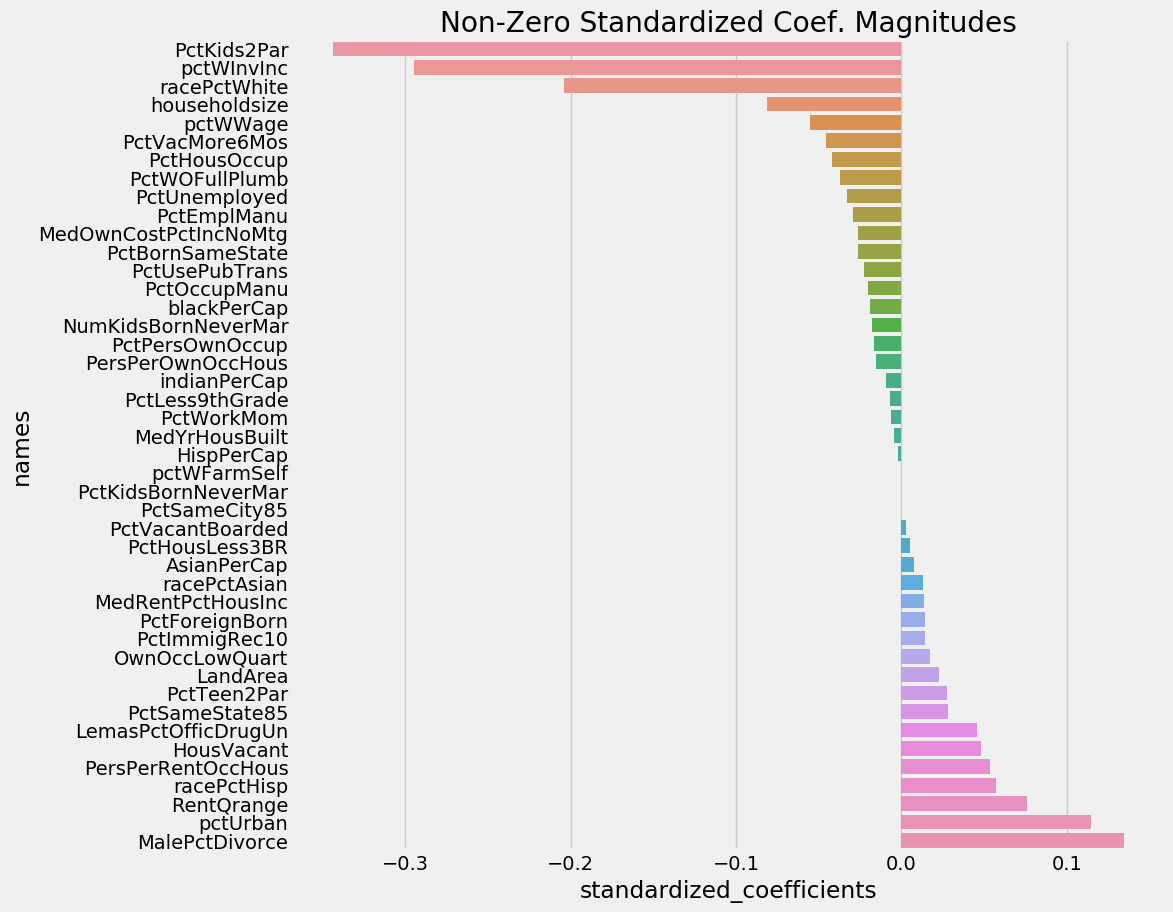

In [240]:
plt.figure(figsize = (10, 10))
g = sns.barplot(x = 'standardized_coefficients', y = 'names', data = l1_coef)
plt.title('Non-Zero Standardized Coef. Magnitudes')
plt.show()

# Lambda Search

In [241]:
coef_path = glm_model.getGLMRegularizationPath(glm_model)['coefficients']
coef_path_df = pd.concat([pd.DataFrame(coef_path[i], index = [1]) for i in range(len(coef_path))])
coef_path_df['lambdas'] = glm_model.getGLMRegularizationPath(glm_model)['lambdas']

In [242]:
top10 = list(l1_coef.sort_values('abs', ascending = False).reset_index(drop = True).loc[:10, 'names'])
coef_path_df = coef_path_df[top10 + ['lambdas']]

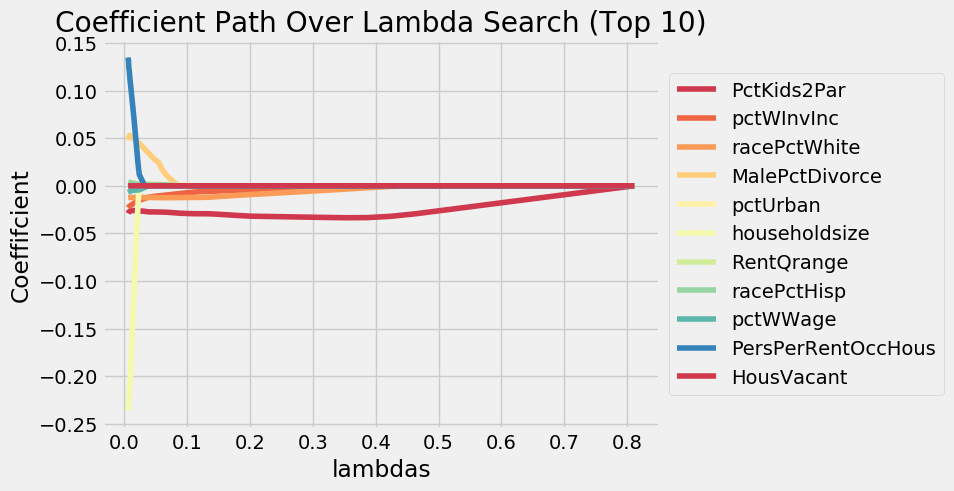

In [243]:
sns.set_palette('Spectral', n_colors = 10)
for col in coef_path_df.columns[:-1]:
    sns.lineplot(x = 'lambdas', y = col, data = coef_path_df, 
                 label = col)

plt.ylabel('Coeffifcient')
plt.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
plt.title("Coefficient Path Over Lambda Search (Top 10)")
plt.show()

In [52]:
# %%html
# <style>
# /* Any CSS style can go in here. */
# .dataframe th {
#     font-size: 30px;
# }
# .dataframe td {
#     font-size: 25px;
# }
# </style>

In [244]:
rmse_df = pd.DataFrame({"Model" : ['OLS', 'LASSO'],
                        "Train RMSE" : [round(ols_model.rmse(train = True), 3),
                                        round(glm_model.rmse(train = True), 3)],
                        "CV RMSE" : [round(ols_model.rmse(xval = True), 3),
                                     round(glm_model.rmse(xval = True), 3)]})

In [245]:
th_props = [
  ('font-size', '20px')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '18px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

rmse_df.style.format({'Train RMSE': "{:.4}", 'CV RMSE': "{:.4}"}).set_table_styles(styles)

,Model,Train RMSE,CV RMSE
0,OLS,0.636,0.712
1,LASSO,0.655,0.705


# Gradient Boosting Machines

# Decision Tree Primer

# Why Trees?

### Pros
- Highly interpretable
- Interactions for free
- Natural handling of categorical predictors
- No assumptions

### Cons
- Empirically demonstrated to overfit easily
- Greedy, stuck in local optima

![](imgs/DT1.png)

[source](https://bradleyboehmke.github.io/HOML/DT.html)

![](imgs/DT2.png)

[source](https://bradleyboehmke.github.io/HOML/DT.html)

# How to fit Regression Tree?

Recursively perform the following

    For j in variables

        For s in split points
    
      		compute loss in each side of the split
            

Split the data at j, s such that the loss is minimized. Repeat until stopping criterion

Take the loss function to be sum of squares

$$f(x) = \sum_{m=1}^M c_m I(x \in r_m)$$

$$\hat c_m = \text{ave} (y_i | x_i \in R_m)$$

$$R_1(j, s) = {X|X_j \leq s} \quad \text{and} \quad R_2(j, s) = {X|X_j > s}$$

$$\min_{j, s} \left[ \min_{c_1} \sum_{x_i \in R_1(j, s)} (y_i - c_1)^2 +  \min_{c_2} \sum_{x_i \in R_1(j, s)} (y_i - c_2)^2 \right]$$

$$\hat c_1 = \text{ave}(y_i |x_i \in R_1(j, s)) \quad \text{and} \quad \hat c_2 = \text{ave}(y_i |x_i \in R_2(j, s))$$

$$\min_{j, s} \left[ \sum_{x_i \in R_1(j, s)} (y_i - \bar y_i)^2 + \sum_{x_i \in R_1(j, s)} (y_i - \bar y_i)^2 \right]$$

In [137]:
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.tree import H2OTree

In [246]:
rmses = {"Train" : list(),
         "CV" : list()}

for depth in range(1, 6):
    
    gbm_model = H2OGradientBoostingEstimator(ntrees = 1,
                                             fold_column = 'state',
#                                              nfolds = 10,
                                             max_depth = depth,
                                             seed = 69)
    gbm_model.train(x = predictors, y = logtarget, training_frame=full)
    
    ### Save RMSES
    rmses['Train'].append(round(gbm_model.rmse(train = True), 3))
    rmses['CV'].append(round(gbm_model.rmse(xval = True), 3))
    
    ### Save MOJO
    gbm_model.download_mojo(path="/Users/gabrieltaylor/Python/STAT527/DTmodels/model" + str(depth) + ".zip", get_genmodel_jar=False)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [140]:
! bash maketree.sh 1
! bash maketree.sh 2
! bash maketree.sh 3
! bash maketree.sh 4
! bash maketree.sh 5

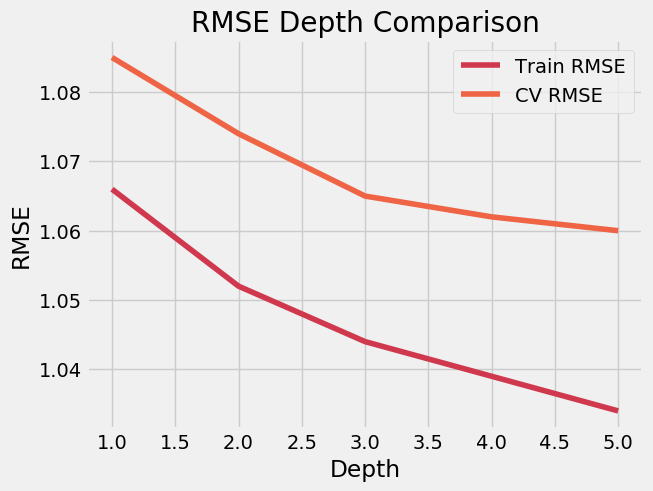

In [247]:
dtrmses = pd.DataFrame(rmses).reset_index()
dtrmses["index"] = dtrmses["index"] + 1
sns.lineplot(x= 'index', y = 'Train', data = dtrmses, label = "Train RMSE")
sns.lineplot(x= 'index', y = 'CV', data = dtrmses, label = "CV RMSE")
plt.legend()
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.title('RMSE Depth Comparison')
plt.show()

In [248]:
rmse_df = pd.concat([rmse_df,
                     pd.DataFrame({'Model' : "Decision Tree",
                                   'Train RMSE' : rmses['Train'][4],
                                   'CV RMSE' : rmses['CV'][4]}, index = [2])
                     ])

rmse_df.style.format({'Train RMSE': "{:.4}", 'CV RMSE': "{:.4}"}).set_table_styles(styles)

,Model,Train RMSE,CV RMSE
0,OLS,0.636,0.712
1,LASSO,0.655,0.705
2,Decision Tree,1.034,1.06


# Boosting

### How to boost decision trees

Sequentially fitting additive decision trees in stagewise fashion.

![](imgs/gbdt_attractive_picture.png)

![](imgs/GBMalg.png)

![](imgs/gradients.png)

![](imgs/GBMalg-ann.png)

Take

$$L(x, y) = 0.5(x - y)^2$$

$$\frac{d}{dy}L(x, y) = -(x - y)$$

Then

$$r_{im} = -\left[\frac{d L(y_i, f(x_i)}{df(x_i} \right]_{f = f_{m-1}} = y_i - f_{m-1}(x_i)$$

Also

$$\gamma_{jm} = \arg \min_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, f_{m-1}(x_i) + \gamma)$$

we can simply take

$$\frac{d}{d \gamma}\sum_{x_i \in R_{jm}} L(y_i, f_{m-1}(x_i) + \gamma)$$

$$\frac{d}{d \gamma}\sum_{x_i \in R_{jm}} 0.5(y_i - f_{m-1}(x_i) - \gamma)^2$$

$$= -\sum_{x_i \in R_{jm}} (y_i - f_{m-1}(x_i) - \gamma) = 0$$

$$= -\sum_{x_i \in R_{jm}} (r_{im} - \gamma) = 0$$

$$\gamma = \frac{1}{n_{jm}}\sum_{x_i \in R_{jm}} r_{im}$$

### Data Preprocessing

- No longer required to One-Hot encode categorical predictors. In fact, OHE has been shown to be deleterious with trees. 

- Each tree will consider splitting at $2^{q-1} - 1$ possible partitions for $q$ levels. 

- Scale invariant (log-transforms or standardizations not required)

### Tuning

- Number of Trees (more trees -> overfit)
- Maximum Depth (deeper -> overfit)
- Learning Rate (larger -> overfit)
- Sampling Rates (larger -> overfit)
- Minimum Node Size (smaller -> overfit)

Use 10-fold cross validation to search for best parameters.

In [143]:
gbm_params = { 'learn_rate': [0.1, 0.2, 0.3],
               'max_depth': [1, 2, 3, 4],
               'ntrees' : [25, 50, 100],
               'categorical_encoding' : 'enum'}

gbm_grid = H2OGridSearch(model = H2OGradientBoostingEstimator,
                         hyper_params = gbm_params)


gbm_grid.train(x = predictors, 
               y = target,
               training_frame = full,
               fold_column = 'state',
               seed = 69)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
     categorical_encoding  learn_rate  max_depth  ntrees  \
0                    Enum         0.1        1.0   100.0   
1                    Enum         0.3        1.0    50.0   
2                    Enum         0.2        2.0    25.0   
3                    Enum         0.2        2.0    50.0   
4                    Enum         0.1        2.0    50.0   
5                    Enum         0.2        1.0    50.0   
6                    Enum         0.3        1.0    25.0   
7                    Enum         0.2        1.0   100.0   
8                    Enum         0.3        1.0   100.0   
9                    Enum         0.1        2.0   100.0   
10                   Enum         0.3        2.0    25.0   
11                   Enum         0.2        2.0   100.0   
12                   Enum         0.3        2.0    50.0   
13                   Enum         0.1        1.0    50.0   
14   

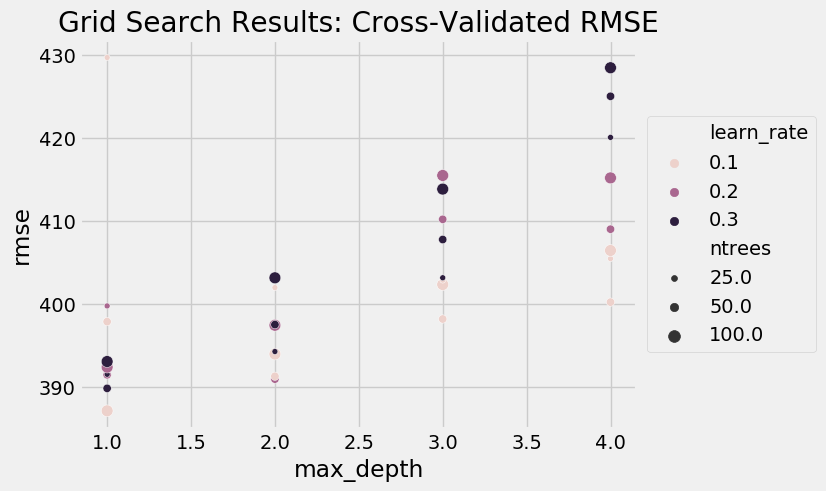

In [144]:
results_df = gbm_grid.get_grid(sort_by='rmse', decreasing=False).sorted_metric_table()
sns.scatterplot(x = 'max_depth', y = 'rmse', hue = "learn_rate", size = "ntrees", data = results_df)
plt.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
plt.title("Grid Search Results: Cross-Validated RMSE")
plt.show()

In [249]:
gbm_model = H2OGradientBoostingEstimator(fold_column = 'state', 
                                         distribution = 'gaussian',
                                         ntrees = 100,
                                         max_depth = 1,
                                         learn_rate = 0.1,
                                         sample_rate = 1,
                                         col_sample_rate = 0.8,
                                         seed = 69)
gbm_model.train(x = predictors, y = logtarget, training_frame=full)

print("Training RMSE: " + str(round(gbm_model.rmse(train = True), 3)))
print("Cross Validation RMSE: " + str(round(gbm_model.rmse(xval = True), 3)))

gbm Model Build progress: |█████████████████ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_8bfd360204d45bb68515db3379b34a73> was cancelled by the user.

### Summary

### Best Model

- Number of Trees: 100
- Maximum Depth: 1
- Learning Rate: 0.1


In [221]:
var_imp_df = gbm_model.varimp(use_pandas = True)
var_imp_df.loc[:10, ["variable", "scaled_importance"]]

,variable,scaled_importance
0,PctKids2Par,1.000000
1,PctKidsBornNeverMar,0.811021
2,NumKidsBornNeverMar,0.362513
3,racePctWhite,0.317646
4,PctFam2Par,0.218866
5,PctPersDenseHous,0.111878
6,FemalePctDiv,0.084736
7,pctWInvInc,0.073914
8,NumStreet,0.063360
9,MalePctDivorce,0.049111


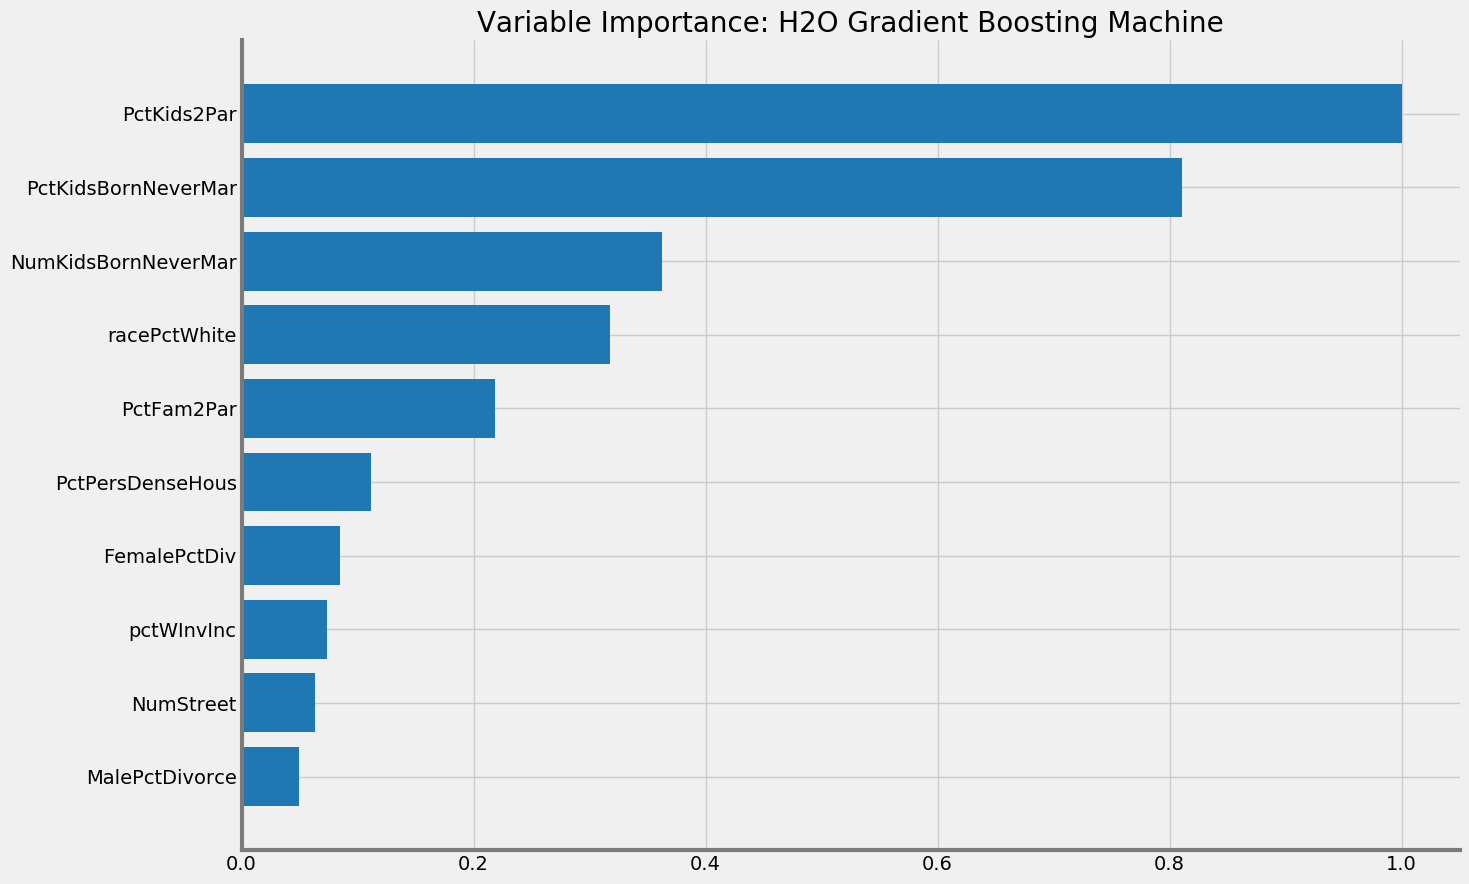

In [147]:
gbm_model.varimp_plot()

# Compare Models

In [218]:
rmse_df = pd.concat([rmse_df,
                     pd.DataFrame({'Model' : "GBM",
                                   'Train RMSE' : round(gbm_model.rmse(train = True), 3),
                                   'CV RMSE' : round(gbm_model.rmse(xval = True), 3)}, index = [3])
                     ])
rmse_df.style.format({'Train RMSE': "{:.4}", 'CV RMSE': "{:.4}"}).set_table_styles(styles)

,Model,Train RMSE,CV RMSE
0,OLS,350.3,417.5
1,LASSO,365.0,390.6
2,Decision Tree,573.7,587.3
3,GBM,348.2,392.8


In [222]:
ols_preds = ols_model.predict(full).as_data_frame()
lasso_preds = glm_model.predict(full).as_data_frame()
imported_model = h2o.import_mojo('DTmodels/model2.zip')
dt_preds = imported_model.predict(full).as_data_frame()
gbm_preds = gbm_model.predict(full).as_data_frame()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1637777366396_2866


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,1.0,1.0,108.0,2.0,2.0,2.0,4.0,4.0,4.0




ModelMetricsRegressionGeneric: generic
** Reported on train data. **

MSE: 340221.87304748484
RMSE: 583.2854130247771
MAE: 422.45106780851853
RMSLE: 1.1821818443460814
Mean Residual Deviance: 340221.87304748484

ModelMetricsRegressionGeneric: generic
** Reported on cross-validation data. **

MSE: 349630.3090501158
RMSE: 591.2954498811198
MAE: 429.30300606457536
RMSLE: 1.1942118844193215
Mean Residual Deviance: 349630.3090501158

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,...,cv_37_valid,cv_38_valid,cv_39_valid,cv_40_valid,cv_41_valid,cv_42_valid,cv_43_valid,cv_44_valid,cv_45_valid,cv_46_valid
0,mae,4.512608e+02,311.222500,315.353300,6.963975e+02,483.643620,294.837950,412.779720,357.909030,448.291870,...,334.424870,384.893400,329.858670,351.469240,317.238130,466.154400,326.126530,409.176060,344.117030,299.413540
1,mean_residual_deviance,4.156468e+05,810853.700000,110182.050000,1.014662e+06,523715.030000,117053.320000,380218.280000,209340.440000,260435.310000,...,128756.440000,248307.480000,189427.190000,143862.700000,139610.440000,218607.390000,172456.060000,178893.640000,164092.400000,103546.680000
2,mse,4.156468e+05,810853.700000,110182.050000,1.014662e+06,523715.030000,117053.320000,380218.280000,209340.440000,260435.310000,...,128756.440000,248307.480000,189427.190000,143862.700000,139610.440000,218607.390000,172456.060000,178893.640000,164092.400000,103546.680000
3,r2,-inf,NaN,-0.004145,-1.412126e-01,0.031923,0.050948,-0.133535,0.029347,-0.426179,...,-6.477492,0.048293,0.054550,-2.914014,0.094516,-68.415750,0.034324,-5.168561,-0.097664,-2.865446
4,residual_deviance,4.156468e+05,810853.700000,110182.050000,1.014662e+06,523715.030000,117053.320000,380218.280000,209340.440000,260435.310000,...,128756.440000,248307.480000,189427.190000,143862.700000,139610.440000,218607.390000,172456.060000,178893.640000,164092.400000,103546.680000
5,rmse,5.520103e+02,336.744140,331.936830,1.007304e+03,723.681600,342.130550,616.618400,457.537350,510.328640,...,358.826480,498.304600,435.232330,379.292360,373.644800,467.554700,415.278300,422.958200,405.083220,321.786680
6,rmsle,1.121176e+00,0.449718,0.960435,1.201864e+00,1.101519,0.765017,0.735958,0.752690,1.767677,...,1.311903,0.925242,0.809061,1.352116,0.895755,1.939767,0.832566,1.674849,1.330720,0.935075



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-11-28 13:17:48,1.151 sec,0.0,614.630341,448.197673,377770.455826
1,,2021-11-28 13:17:48,1.159 sec,1.0,583.285413,422.451068,340221.873047



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,PctKidsBornNeverMar,297975872.0,1.000000,0.756164
1,PctFam2Par,50213264.0,0.168515,0.127425
2,PctKids2Par,45873324.0,0.153950,0.116411
3,PctHousOwnOcc,0.0,0.000000,0.000000
4,PctHousOccup,0.0,0.000000,0.000000
5,HousVacant,0.0,0.000000,0.000000
6,MedNumBR,0.0,0.000000,0.000000
7,PctHousLess3BR,0.0,0.000000,0.000000
8,PctPersDenseHous,0.0,0.000000,0.000000
9,PctPersOwnOccup,0.0,0.000000,0.000000



See the whole table with table.as_data_frame()

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


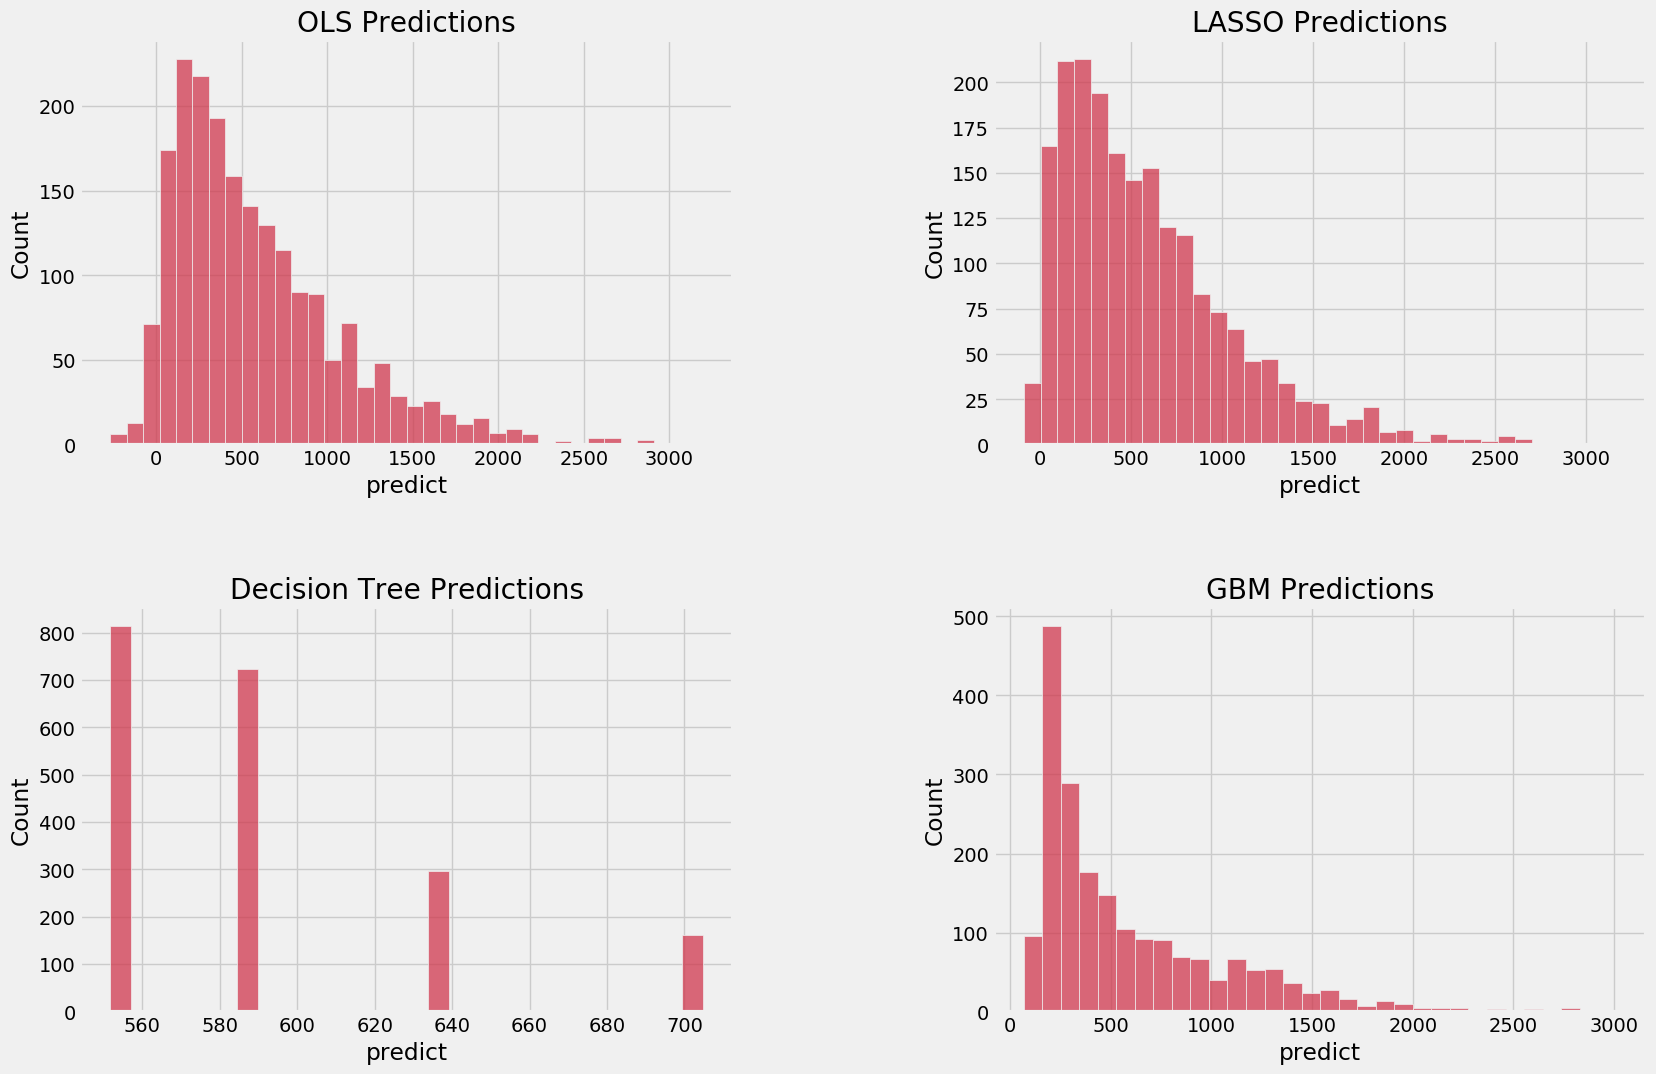

In [223]:
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax1, ax2, ax3, ax4  = axes.flatten()

sns.histplot(x = 'predict', data = ols_preds, ax = ax1)
ax1.title.set_text('OLS Predictions')

sns.histplot(x = 'predict', data = lasso_preds, ax = ax2)
ax2.title.set_text('LASSO Predictions')

sns.histplot(x = 'predict', data = dt_preds, ax = ax3)
ax3.title.set_text('Decision Tree Predictions')

sns.histplot(x = 'predict', data = gbm_preds, ax = ax4)
ax4.title.set_text('GBM Predictions')

plt.show()

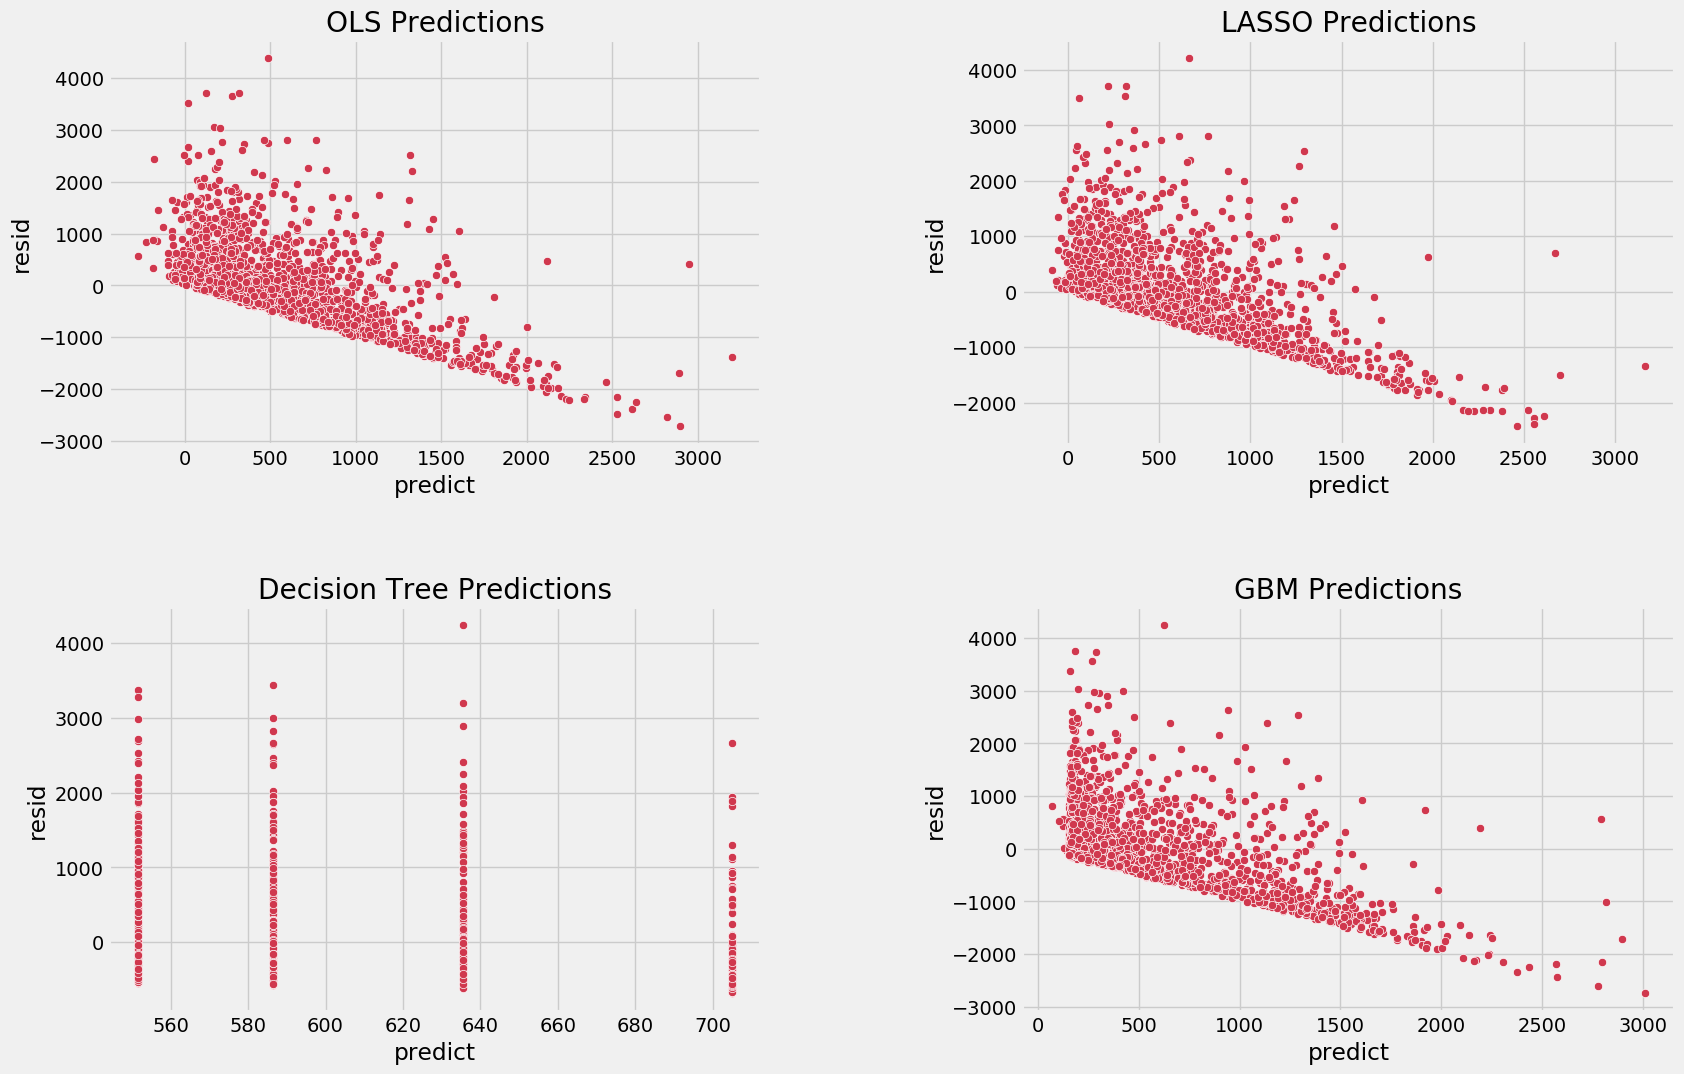

In [224]:
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax1, ax2, ax3, ax4  = axes.flatten()

ols_preds['resid'] = df['ViolentCrimesPerPop'] - ols_preds['predict']
sns.scatterplot(x = 'predict', y = 'resid', data = ols_preds, ax = ax1)
ax1.title.set_text('OLS Predictions')

lasso_preds['resid'] = df['ViolentCrimesPerPop'] - lasso_preds['predict']
sns.scatterplot(x = 'predict', y = 'resid', data = lasso_preds, ax = ax2)
ax2.title.set_text('LASSO Predictions')

dt_preds['resid'] = df['ViolentCrimesPerPop'] - dt_preds['predict']
sns.scatterplot(x = 'predict', y = 'resid', data = dt_preds, ax = ax3)
ax3.title.set_text('Decision Tree Predictions')

gbm_preds['resid'] = df['ViolentCrimesPerPop'] - gbm_preds['predict']
sns.scatterplot(x = 'predict', y = 'resid', data = gbm_preds, ax = ax4)
ax4.title.set_text('GBM Predictions')

plt.show()

# Conclusion

My Github: https://github.com/gabeztaylor/STAT527

### Resources

Data Source: https://archive.ics.uci.edu/ml/datasets/student+performance

H2o Documentation: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science.html

ESL: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12_toc.pdf

BSL: https://statisticallearning.org/

Hands-on Machine Learning: https://bradleyboehmke.github.io/HOML/gbm.html

In [100]:
# gbm_model.explain(full)